##### Copyright 2020 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title ##### Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# VIB + DoSE

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/python/experimental/nn/examples/vib_dose.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/python/experimental/nn/examples/vib_dose.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this example, we train a deep variational information bottleneck model (VIB) on the MNIST dataset.  We then use density of states estimation to turn our VIB model into an Out-of-distribution (OOD) detector.  Our current implementation achieves near-SOTA performance on both OOD detection and classification simultaneously without any exposure to OOD data during training.

## References

The VIB paper (Alemi et al. 2016) can be found [Here](https://arxiv.org/abs/1612.00410)

The DoSE paper (Morningstar et al. 2020) can be found [Here](https://arxiv.org/abs/2006.09273)

### 1  Imports

In [0]:
import functools
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

# Globally Enable XLA.
# tf.config.optimizer.set_jit(True)

try:
  physical_devices = tf.config.list_physical_devices('GPU')
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

tfb = tfp.bijectors
tfd = tfp.distributions
tfn = tfp.experimental.nn

### 2  Load Dataset

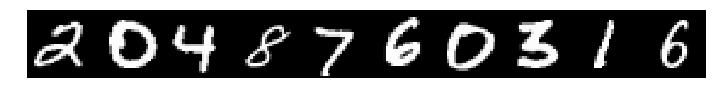

(<Figure size 1000x200 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f32fd30ce48>)

In [0]:
[train_dataset, eval_dataset], datasets_info = tfds.load(
    name='mnist',
    split=['train', 'test'],
    with_info=True,
    shuffle_files=True)

def _preprocess(sample):
  return (tf.cast(sample['image'], tf.float32) * 2 / 255. - 1.,
          tf.cast(sample['label'], tf.int32))

train_size = datasets_info.splits['train'].num_examples
batch_size = 32

train_dataset = tfn.util.tune_dataset(
    train_dataset,
    batch_size=batch_size,
    shuffle_size=int(train_size  / 7),
    preprocess_fn=_preprocess)

eval_dataset = tfn.util.tune_dataset(
    eval_dataset,
    repeat_count=1,
    preprocess_fn=_preprocess)

x = next(iter(eval_dataset.batch(10)))[0]
tfn.util.display_imgs(x)

### 3  Define Model

In [0]:
input_shape = datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

In [0]:
prior = tfd.MultivariateNormalDiag(
    loc=tf.zeros(encoded_size),
    scale_diag=tf.ones(encoded_size))

In [0]:
Conv = functools.partial(
    tfn.Convolution,
    init_bias_fn=tf.zeros_initializer(),
    init_kernel_fn=tf.keras.initializers.he_uniform())  # Better for leaky_relu.

encoder = tfn.Sequential([
    lambda x: 2. * tf.cast(x, tf.float32) - 1.,  # Center.
    Conv(1, 1 * base_depth, 5, strides=1, padding='same'),
    tf.nn.leaky_relu,
    Conv(1 * base_depth, 1 * base_depth, 5, strides=2, padding='same'),
    tf.nn.leaky_relu,
    Conv(1 * base_depth, 2 * base_depth, 5, strides=1, padding='same'),
    tf.nn.leaky_relu,
    Conv(2 * base_depth, 2 * base_depth, 5, strides=2, padding='same'),
    tf.nn.elu,
    Conv(2 * base_depth, 4 * encoded_size, 7, strides=1, padding='valid'),
    tf.nn.leaky_relu,
    tfn.util.flatten_rightmost(ndims=3),
    tfn.Affine(4*encoded_size, encoded_size + encoded_size * (encoded_size + 1) // 2),
    lambda x: tfd.MultivariateNormalTriL(
        loc=x[..., :encoded_size],
        scale_tril=tfb.FillScaleTriL()(x[..., encoded_size:]))
], name='encoder')

print(encoder.summary())

=== encoder ==================================================
  SIZE SHAPE                TRAIN NAME                                    
    32 [32]                 True  bias:0                                  
   800 [5, 5, 1, 32]        True  kernel:0                                
    32 [32]                 True  bias:0                                  
 25600 [5, 5, 32, 32]       True  kernel:0                                
    64 [64]                 True  bias:0                                  
 51200 [5, 5, 32, 64]       True  kernel:0                                
    64 [64]                 True  bias:0                                  
102400 [5, 5, 64, 64]       True  kernel:0                                
    64 [64]                 True  bias:0                                  
200704 [7, 7, 64, 64]       True  kernel:0                                
   152 [152]                True  bias:0                                  
  9728 [64, 152]            True  ker

In [0]:
DeConv = functools.partial(
    tfn.ConvolutionTranspose,
    init_kernel_fn=tf.keras.initializers.he_uniform())  # Better for leaky_relu.
    
Affine = functools.partial(
    tfn.Affine,
    init_kernel_fn=tf.keras.initializers.he_uniform())

decoder = tfn.Sequential([
    Affine(encoded_size, 10),
    lambda x: tfd.Categorical(logits=x)])

print(decoder.summary())

=== Affine__lambda ==================================================
  SIZE SHAPE                TRAIN NAME                                    
    10 [10]                 True  bias:0                                  
   160 [16, 10]             True  kernel:0                                
trainable size: 170  /  0.001 MiB  /  {float32: 170}


### 4  Loss / Eval

In [0]:
def compute_loss(x, y, beta=1.):
  q = encoder(x)
  z = q.sample()
  p = decoder(z)
  kl = tf.reduce_mean(q.log_prob(z) - prior.log_prob(z), axis=-1)
  # Note: we could use exact KL divergence, eg:
  #   kl = tf.reduce_mean(tfd.kl_divergence(q, prior))
  # however we generally find that using the Monte Carlo approximation has
  # lower variance.
  nll = -tf.reduce_mean(p.log_prob(y), axis=-1)
  loss = nll + beta * kl
  return loss, (nll, kl), (q, z, p)

In [0]:
train_iter = iter(train_dataset)

def loss():
  x, y = next(train_iter)
  loss, (nll, kl), _ = compute_loss(x, y, beta=0.075)
  return loss, (nll, kl)

opt = tf.optimizers.Adam(learning_rate=1e-3, decay=0.00005)

fit = tfn.util.make_fit_op(
    loss,
    opt,
    decoder.trainable_variables + encoder.trainable_variables,
    grad_summary_fn=lambda gs: tf.nest.map_structure(tf.norm, gs))

In [0]:
eval_iter = iter(eval_dataset.batch(5000).repeat())

@tfn.util.tfcompile
def eval():
  x, y = next(eval_iter)
  loss, (nll, kl), _ = compute_loss(x, y, beta=0.05)
  return loss, (nll, kl)

### 5  Train

In [0]:
DEBUG_MODE = False
tf.config.experimental_run_functions_eagerly(DEBUG_MODE)

In [0]:
num_train_epochs = 25.  # @param { isTemplate: true}
num_evals = 200        # @param { isTemplate: true}

dur_sec = dur_num = 0
num_train_steps = int(num_train_epochs * train_size // batch_size)
for i in range(num_train_steps):
  start = time.time()
  trn_loss, (trn_nll, trn_kl), g = fit()
  stop = time.time()
  dur_sec += stop - start
  dur_num += 1
  if i % int(num_train_steps / num_evals) == 0 or i == num_train_steps - 1:
    tst_loss, (tst_nll, tst_kl) = eval()
    f, x = zip(*[
        ('it:{:5}', opt.iterations),
        ('ms/it:{:6.4f}', dur_sec / max(1., dur_num) * 1000.),
        ('trn_loss:{:6.4f}', trn_loss),
        ('tst_loss:{:6.4f}', tst_loss),
        ('tst_nll:{:6.4f}', tst_nll),
        ('tst_kl:{:6.4f}', tst_kl),
        ('sum_norm_grad:{:6.4f}', sum(g)),

    ])
    print('   '.join(f).format(*[getattr(x_, 'numpy', lambda: x_)()
                                 for x_ in x]))
    sys.stdout.flush()
    dur_sec = dur_num = 0
  # if i % 1000 == 0 or i == maxiter - 1:
  #   encoder.save('/tmp/encoder.npz')
  #   decoder.save('/tmp/decoder.npz')

it:    1   ms/it:2564.3797   trn_loss:22.1861   tst_loss:19.4266   tst_nll:10.1761   tst_kl:185.0093   sum_norm_grad:845.5634
it:  235   ms/it:2.2164   trn_loss:1.5428   tst_loss:1.3213   tst_nll:0.9611   tst_kl:7.2048   sum_norm_grad:14.4196
it:  469   ms/it:2.1324   trn_loss:0.9982   tst_loss:0.9201   tst_nll:0.5909   tst_kl:6.5845   sum_norm_grad:10.1642
it:  703   ms/it:2.1391   trn_loss:0.9315   tst_loss:0.7142   tst_nll:0.3821   tst_kl:6.6419   sum_norm_grad:14.4733
it:  937   ms/it:2.1684   trn_loss:0.9210   tst_loss:0.6675   tst_nll:0.3780   tst_kl:5.7918   sum_norm_grad:14.7734
it: 1171   ms/it:2.1175   trn_loss:0.7251   tst_loss:0.5506   tst_nll:0.2207   tst_kl:6.5989   sum_norm_grad:8.4730
it: 1405   ms/it:2.0846   trn_loss:0.6943   tst_loss:0.5861   tst_nll:0.3270   tst_kl:5.1835   sum_norm_grad:9.5136
it: 1639   ms/it:2.1750   trn_loss:0.6642   tst_loss:0.5858   tst_nll:0.3445   tst_kl:4.8274   sum_norm_grad:6.8234
it: 1873   ms/it:2.0080   trn_loss:0.5778   tst_loss:0.537

### 6  Evaluate Classification Accuracy

In [0]:
def evaluate_accuracy(dataset, encoder, decoder):
  """Evaluate the accuracy of your model on a dataset.
  """
  this_it = iter(dataset)
  num_correct = 0
  num_total = 0
  attempts = 0
  for xin, xout in this_it:
    xin, xout = next(this_it)
    e = encoder(xin)
    z = e.sample(10000)  # 10K samples should have low variance.
    d = decoder(z)
    yhat = d.sample()
    confidence = tf.reduce_mean(d.probs_parameter(), axis=0)
    most_likely = tf.cast(tf.math.argmax(confidence, axis=-1), tf.int32)
    num_correct += np.sum(most_likely == xout, axis=0)
    num_total += xout.shape[0]
    attempts +=1
  return num_correct, num_total

In [0]:
nc, nt = evaluate_accuracy(eval_dataset.batch(100), encoder, decoder)
print("Accuracy:  %.4f"%(nc/nt))

Accuracy:  0.9930


The accuracy of one training run with this particular model and training setup was 99.15%, which is within a half of a percent of the state of the art, and comparable to the mnist accuracy reported in Alemi et al. (2016).

# OOD detection using DoSE

From the previous section, we have trained a variational classifier.  However, this classifier was trained assuming that all of the inputs are from the distribution which generated the training set.  In general, we may not always receive images drawn from this distribution.  In these situations, our model prediction is unreliable.  We want to be able to identify when this may be the case to avoid serving these flawed predictions.  

In this section, we turn the VIB classifier into an OOD detector using DoSE.

### 1 Get statistics

In [0]:
def get_statistics(encoder, decoder, prior):
  """Setup a function to evaluate statistics given model components.
  
  Args:
    encoder:  Callable neural network which takes in an image and 
      returns a tfp.distributions.Distribution object.
    decoder: Callable neural network which takes in a vector and 
      returns a tfp.distributions.Distribution object.
    prior:  A tfp.distributions.Distribution object which operates 
      on the same spaces as the encoder.
  Returns:
    T:  A function, which takes in a tensor containing an image (or 
      batch of images) and evaluates statistics on the model.  
      Optionally it  also returns the prediction, under the assumption 
      that the DoSE model will only dress an actual classifier.
  """
  def T(x, return_pred=False):
    """Evaluate statistics on an input image or batch of images.
    
    Given an input tensor `x` containing either an image or a batch of 
    images, this function evaluates 4 statistics on a VIB model;  the
    kl-divergence between the posterior and prior, the expected entropy
    of the decoder computed using samples from the posterior, the 
    posterior entopy, and the cross-entropy between the posterior and
    the prior.  We also allow for the prediction to be optionally
    returned.

    Args: 
      x:  rank 4 tensor containing a batch of images
      return_pred:  Bool indicating whether to return the model
        prediction.
    Returns:
      tf.tensor containing the 4 statistics evaluated on the input.
      pred (optional):  The prediction of the model.
    """
    pzgx = encoder(x)
    z = pzgx.sample(100, seed=42) # Seed is fixed for determinism.
    pxgz = decoder(z)

    kl = pzgx.kl_divergence(prior)[tf.newaxis,...]
    dent = tf.reduce_mean(pxgz.entropy(), axis=0)[tf.newaxis,...]
    eent = pzgx.entropy()[tf.newaxis,...]
    xent = pzgx.cross_entropy(prior)[tf.newaxis,...]
    if return_pred:
      pred = tf.math.argmax(
          tf.reduce_mean(pxgz.probs_parameter, axis=0), 
          axis=-1)
      return tf.concat([kl, dent, eent, xent], axis=0), pred
    else:
      return tf.concat([kl, dent, eent, xent], axis=0)
  return T

In [0]:
T = get_statistics(encoder, decoder, prior)

### 2 Define DoSE helper classes and functions

In [0]:
def get_DoSE_KDE(T, dataset):
  """Get a distribution and decision rule for OOD detection using DoSE.

  Given a tensor of statistics tx, compute a Kernel Density Estimate (KDE) of
  the statistics.  This uses a quantiles trick to cut down the number of 
  samples used in the KDE (to lower the cost of evaluating a trial point).

  Args:
    T:  A function which takes an input image and returns a vector of
      statistics evaluated using the model.
    dataset:  A tensorflow_datasets `Dataset` which will be used to evaluate
      statistics to construct the estimator.
  Returns:
    is_ood:  A function which takes a new point `x` and `threshold`, and 
      computes the decision rule KDE.log_prob(T(x)) < threshold
    dose_kde:  A tfd.MixtureSameFamily object.  The distribution used as the KDE
      from which the log_prob of a batch of statistics can be computed.
  """

  # First we should evaluate the statistics on the training set.
  it = iter(dataset)
  for x, y in it:
    if not "tx" in locals():
      tx = T(x)
    else:
      tx = tf.concat([tx, T(x)], axis=-1)

  n = tf.cast(tf.shape(tx)[-1], tx.dtype)
  num_quantiles = int(25)
  q = tfp.stats.quantiles(tx, num_quantiles, axis=-1)
  q = tf.transpose(q, tf.roll(tf.range(tf.rank(q)), shift=-1, axis=0))
  # Scott's Rule:
  h = 3.49 * tf.math.reduce_std(tx, axis=-1, keepdims=True) * (n)**(-1./3.)
  h *= n / num_quantiles
 
  dose_kde = tfd.Independent(
      tfd.MixtureSameFamily(
          mixture_distribution=tfd.Categorical(logits=tf.zeros(num_quantiles + 1)),
          components_distribution=tfd.Normal(loc=q, scale=h)),
      reinterpreted_batch_ndims=1)
  is_ood = lambda x, threshold: dose_kde.log_prob(tf.transpose(T(x), [1, 0])) < tf.math.log(threshold)
  dose_log_prob = lambda x: dose_kde.log_prob(tf.transpose(T(x), [1, 0]))

  # T(x) returns shape [T, N], but dose_kde works on shape [N, T]
  return is_ood, dose_kde, dose_log_prob, tx


class DoSE_administrator(object):
  def __init__(self, T, train_dataset, eval_dataset):
    """Administrate DoSE for model evaluation in a more efficient way.

    This high level object just calls the lower level DoSE methods, but
    also evaluates the DoSE log-probabilities on the evaluation dataset.
    Using these, we can do things like compute auroc much more efficiently.
    """
    dose_build = get_DoSE_KDE(T, train_dataset)
    
    # Call DoSE on an image/batch x for lp threshold `threshold`
    self.is_ood = dose_build[0]

    # Actual dose distribution
    self.dose_dist = dose_build[1]
    self.dose_lp = lambda t: self.dose_dist.log_prob(tf.transpose(t, [1, 0]))

    # Get the log-probability of a batch from dose
    self.dose_log_prob = dose_build[2] 

    # This helps us evaluate auroc more reliably.
    self.training_stats = dose_build[3]
    
    # Get training_log probs efficiently
    train_size = self.training_stats.shape[-1]
    bs = train_size // 1000
    for i in range(1000):
      tlp = self.dose_lp(self.training_stats[..., bs*i:bs*(i+1)])
      if not hasattr(self, 'training_lp'):
        self.training_lp = tlp
      else:
        self.training_lp = tf.concat([self.training_lp, tlp], axis=0)

    # Get log_probs, images, labels, and statistics 
    # on the evaluation dataset.
    eval_it = iter(eval_dataset)
    for x, y in eval_it:
      if not hasattr(self, 'eval_lp'):
        self.eval_stats = T(x)
        self.eval_lp = self.dose_lp(self.eval_stats)
        self.eval_label = y
        self.eval_ims = x
      else:
        tx = T(x)
        self.eval_stats = tf.concat([self.eval_stats,
                                     tx], 
                                    axis=0)
        self.eval_lp = tf.concat([self.eval_lp,
                                  self.dose_lp(tx)],
                                 axis=0)
        self.eval_label = tf.concat([self.eval_label, y], axis=0)
        self.eval_ims = tf.concat([self.eval_ims, x], axis=0)

  
  def get_acc(self, threshold):
    """Evaluate the OOD accuracy for a certain threshold probability.
    
    This computes the decision rule: `log q(x) < tf.math.log(thresh)`
    on the eval dataset.  It uses this decision rule to evaluate the
    number of correct predictions, along with the 4 components of the
    confusion matrix.

    Args:
      threshold:  A threshold on the DoSE probability density.
    Returns:
      nc:  Number of correct predictions
      nt:  Number of total predictions
      tp:  Number of true positives
      tn:  Number of true negatives
      fp:  Number of false positives
      fn:  Number of false negatives
    """

    yhat = self.eval_lp < tf.math.log(threshold)

    fp = tf.reduce_sum(tf.cast(
        tf.logical_and(tf.math.not_equal(yhat, self.eval_label), 
                       tf.equal(self.eval_label, False)),
        tf.int32),axis=0)
    fn = tf.reduce_sum(tf.cast(
        tf.logical_and(tf.math.not_equal(yhat, self.eval_label), 
                       tf.equal(self.eval_label, True)),
        tf.int32),axis=0)
    tp = tf.reduce_sum(tf.cast(
        tf.logical_and(tf.equal(yhat, self.eval_label), 
                       tf.equal(self.eval_label, True)),
        tf.int32),axis=0)
    tn = tf.reduce_sum(tf.cast(
        tf.logical_and(tf.equal(yhat, self.eval_label), 
                       tf.equal(self.eval_label, False)),
        tf.int32),axis=0)
    nc = tp+tn
    nt = tf.cast(tf.size(self.eval_label), tf.float32) 
    return nc, nt, tp, tn, fp, fn
  
  def roc_curve(self, nbins):
    """Get the roc curve for the model."""

    nc, nt, tp, tn, fp, fn = self.get_acc(
        np.float32(np.exp(np.percentile(self.eval_lp, 0.))))
    fpr = [fp.numpy() / (fp.numpy()+tn.numpy())]
    tpr = [tp.numpy()/ (tp.numpy() + fn.numpy())]
    for i in range(1, nbins+1):
      nc, nt, tp, tn, fp, fn = self.get_acc(
        np.float32(np.exp(np.percentile(self.eval_lp, i/float(nbins)*100.))))
      fpr.append(fp.numpy()/ (fp.numpy() + tn.numpy()))
      tpr.append(tp.numpy()/ (tp.numpy() + fn.numpy()))
    return fpr, tpr

  def precision_recall_curve(self, nbins):
    """Get the precision-recall curve for the model."""

    nc, nt, tp, tn, fp, fn = self.get_acc(
        np.float32(np.exp(np.percentile(self.eval_lp, 0.))))
    precision = [tp.numpy()/ (tp.numpy() + fp.numpy())]
    recall = [tp.numpy() / (tp.numpy() + fn.numpy())]
    for i in range(1, nbins+1):
      nc, nt, tp, tn, fp, fn = self.get_acc(
        np.float32(np.exp(np.percentile(self.eval_lp, i/float(nbins)*100.))))
      precision.append(tp.numpy()/ (tp.numpy() + fp.numpy()))
      recall.append(tp.numpy() / (tp.numpy() + fn.numpy()))
    return precision, recall

### 3 Setup OOD dataset

In [0]:
# For evaluating statistics on the training set, we need to perform a
# pass through the dataset.
train_one_pass = tfds.load('mnist')['train']
train_one_pass = tfn.util.tune_dataset(train_one_pass, 
                                       batch_size=1000,
                                       repeat_count=None,
                                       preprocess_fn=_preprocess)

In [0]:
# OOD dataset is Fashion_MNIST
ood_data = tfds.load('fashion_mnist')['test'].map(_preprocess).map(
    lambda x, y: (x, tf.ones_like(y, dtype=tf.bool)))

# In-distribution data is the MNIST test set.
ind_data = tfds.load('mnist')['test'].map(_preprocess).map(
    lambda x, y: (x, tf.zeros_like(y, dtype=tf.bool)))

# Our trial dataset is a 50-50 split of the two.
hybrid_data = ind_data.concatenate(ood_data)
hybrid_data = tfn.util.tune_dataset(hybrid_data, batch_size=100,
                                    shuffle_size=20000,repeat_count=None)

### 4 Administer DoSE

In [0]:
DoSE_admin = DoSE_administrator(T, train_one_pass, hybrid_data)

### 5 Evaluate OOD performance

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_gpu_wmorning.kernel.wmorning.579822584826.14b334fb3717c109/mount/server/ml_notebook:162: RuntimeWarning: invalid value encountered in int_scalars


Text(0.5, 1.0, 'AUPRC: 0.9896')

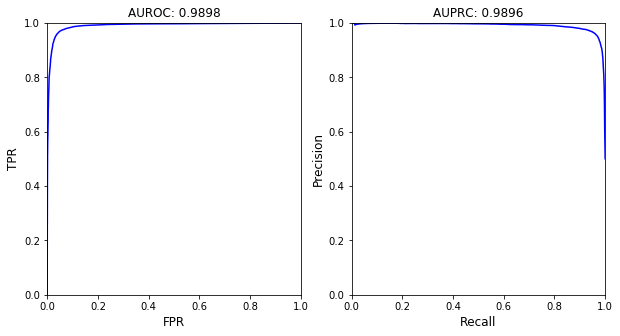

In [0]:
fp, tp = DoSE_admin.roc_curve(10000)
precision, recall = DoSE_admin.precision_recall_curve(10000)
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(fp, tp, 'b-')
plt.xlim(0, 1.)
plt.ylim(0., 1.)
plt.xlabel('FPR', fontsize=12)
plt.ylabel('TPR', fontsize=12)
plt.title("AUROC: %.4f"%np.trapz(tp, fp), fontsize=12)
plt.subplot(122)
plt.plot(recall, precision, 'b-')
plt.xlim(0, 1.)
plt.ylim(0., 1.)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title("AUPRC: %.4f"%np.trapz(precision[1:], recall[1:]), fontsize=12)

Most False Positive


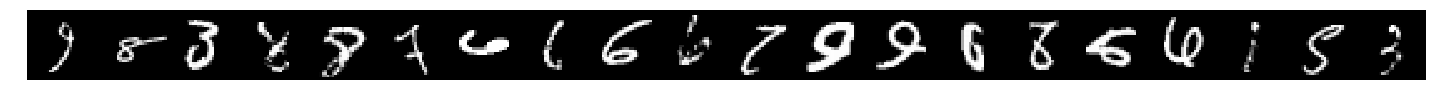

Most True Negative


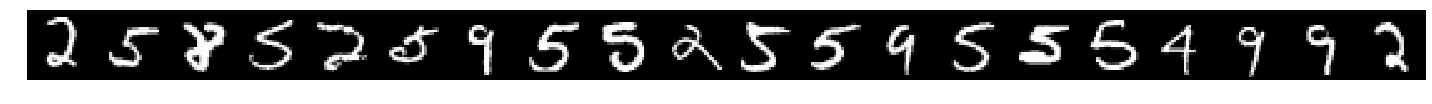

Most False Negative


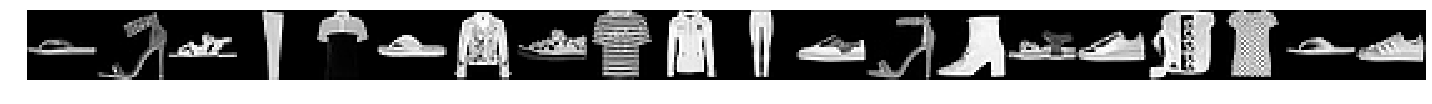

Most True Positive


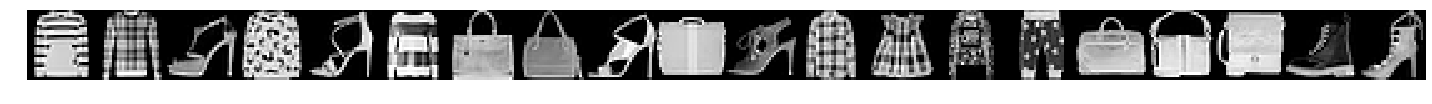

(<Figure size 2000x200 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3051175128>)

In [0]:
Sorted_ims = tf.gather(DoSE_admin.eval_ims, tf.argsort(DoSE_admin.eval_lp))
Sorted_labels = tf.gather(DoSE_admin.eval_label, tf.argsort(DoSE_admin.eval_lp))
sorted_ind = tf.gather(Sorted_ims, tf.where(Sorted_labels == False))[:,0]
sorted_ood = tf.gather(Sorted_ims, tf.where(Sorted_labels == True))[:,0]

print("Most False Positive")
tfn.util.display_imgs(sorted_ind[:20])
print("Most True Negative")
tfn.util.display_imgs(sorted_ind[-20:])
print("Most False Negative")
tfn.util.display_imgs(sorted_ood[-20:])
print("Most True Positive")
tfn.util.display_imgs(sorted_ood[:20])

DoSE on this particular classifier appears to get 0.982-0.993 AUROC and 0.982-0.993 AUPRC.  This is comparable to the accuracy of the classifier itself, but was trained without access to the OOD dataset in question.